<a href="https://colab.research.google.com/github/5ohyun/Dacon_creditcard/blob/main/credit_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google colab mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 패키지 다운로드


Package install

In [2]:
!pip install catboost
!pip install category_encoders

한글 폰트 사용을 위한 설정

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [4]:

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import itertools

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from catboost import CatBoostClassifier, Pool


from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


In [5]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [6]:
sns.set_palette("Set3")

# 데이터 설명


### 변수 설명

**19개의 열과 반응 변수 y (Credit)**


* index : 인덱스
* gender: 성별
* car: 차량 소유 여부
* reality: 부동산 소유 여부
* child_num: 자녀 수
* income_total: 연간 소득

* income_type: 소득 분류

    ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']



* edu_type: 교육 수준

    ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']



* family_type: 결혼 여부

    ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']



* house_type: 생활 방식

    ['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']



* DAYS_BIRTH: 출생일

    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미



* DAYS_EMPLOYED: 업무 시작일

    데이터 수집 당시 (0)부터 역으로 
    즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미
    양수 값은 고용되지 않은 상태를 의미함



* FLAG_MOBIL: 핸드폰 소유 여부


* work_phone: 업무용 전화 소유 여부


* phone: 전화 소유 여부


* email: 이메일 소유 여부


* occyp_type: 직업 유형													


* family_size: 가족 규모


* begin_month: 신용카드 발급 월
			
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미







* credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도

    낮을 수록 높은 신용의 신용카드 사용자를 의미함

	





### ❗ 확인해야할 점 

- 같은 날에 수집한 데이터라고 가정
- 해당 신용카드사에서 한 사용자가 여러 카드를 발급받았을 수 있다. -> 중복 데이터가 있을 수 있다.


### 데이터 불러오기

In [7]:
os.chdir('/content/drive/MyDrive/신용카드/')

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

# EDA

### 데이터 전처리

In [8]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [9]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0
9996,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0
9997,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0
9998,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0


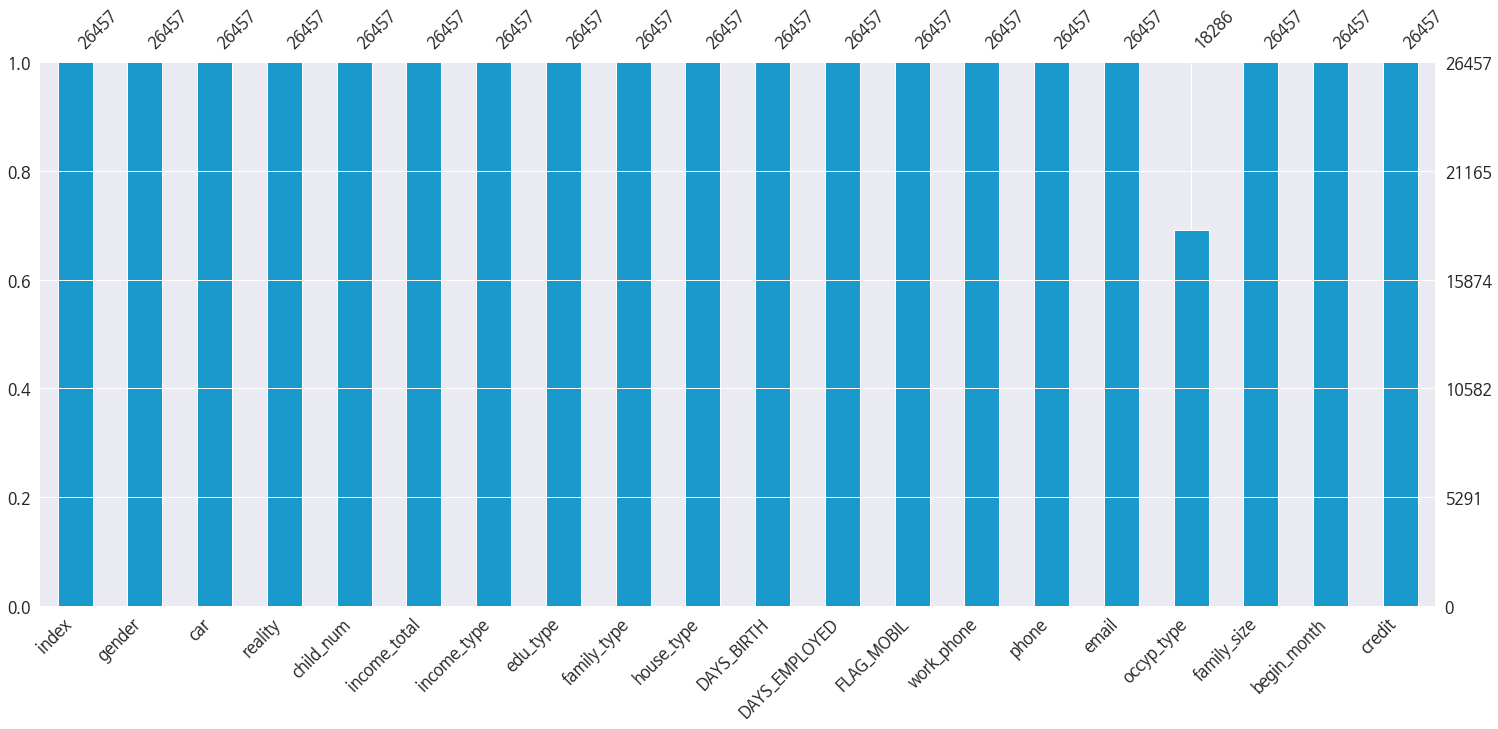

In [10]:
import missingno as msno
msno.bar(df=train.iloc[:, :], color=(0.1, 0.6, 0.8))

- 'occyp_type' 직업 유형 정보가 소실되어 있음을 확인

In [11]:
variable = ['DAYS_BIRTH','DAYS_EMPLOYED','begin_month']

train[variable]=-train[variable]
test[variable]=-test[variable]

- 음수로 나타나있는 변수 -> 양수로 변경

In [12]:
for i in train.columns :
    print(train[i].value_counts())
    print('---------------------')

2047     1
5448     1
3371     1
13612    1
15661    1
        ..
2740     1
693      1
6838     1
4791     1
0        1
Name: index, Length: 26457, dtype: int64
---------------------
F    17697
M     8760
Name: gender, dtype: int64
---------------------
N    16410
Y    10047
Name: car, dtype: int64
---------------------
Y    17830
N     8627
Name: reality, dtype: int64
---------------------
0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64
---------------------
135000.0    3164
157500.0    2233
180000.0    2225
112500.0    2178
225000.0    2170
            ... 
177750.0       1
91530.0        1
87448.5        1
97731.0        1
204750.0       1
Name: income_total, Length: 249, dtype: int64
---------------------
Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64
--------

In [13]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,15958.053899,-59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,7705.000000,-365243.000000,1.0,0.000000,0.000000,0.000000,1.000000,-0.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,12446.000000,407.000000,1.0,0.000000,0.000000,0.000000,2.000000,12.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,15547.000000,1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,19431.000000,3153.000000,1.0,0.000000,1.000000,0.000000,3.000000,39.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,25152.000000,15713.000000,1.0,1.000000,1.000000,1.000000,20.000000,60.000000,2.000000


- 데이터 분포 확인

In [14]:
train = train.drop(columns=['index','FLAG_MOBIL'])
test = test.drop(columns=['index','FLAG_MOBIL'])

- 인덱스 컬럼 삭제
- 데이터가 모두 1로 이루어져 있는 FLAG_MOBIL 컬럼 삭제

In [15]:
train['DAYS_EMPLOYED']= train['DAYS_EMPLOYED'].map(lambda x: 0 if x<=0 else x)
test['DAYS_EMPLOYED']= test['DAYS_EMPLOYED'].map(lambda x: 0 if x<=0 else x)

- 고용된 날짜가 0보다 작으면 무직인 상태로 간주

In [16]:
train['age']=train['DAYS_BIRTH']/365
train['age'] = train['age'].astype('int')

test['age']=test['DAYS_BIRTH']/365
test['age'] = test['age'].astype('int')


- 나이변수 생성

In [17]:
duplicateDFRow = train[train.duplicated()]
duplicateDFRow

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age
419,M,Y,Y,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,18820.0,3185.0,0,1,0,Low-skill Laborers,2.0,7.0,1.0,51
716,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,21497.0,0.0,0,0,0,NaN,1.0,4.0,1.0,58
877,M,Y,N,2,180000.0,State servant,Secondary / secondary special,Married,House / apartment,12240.0,4663.0,0,0,0,Core staff,4.0,24.0,2.0,33
1056,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Married,House / apartment,24665.0,0.0,0,0,0,NaN,2.0,35.0,2.0,67
1315,F,Y,Y,0,130500.0,Working,Secondary / secondary special,Married,House / apartment,16137.0,9391.0,0,1,0,Laborers,2.0,29.0,2.0,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26374,F,Y,N,0,112500.0,Working,Secondary / secondary special,Married,Municipal apartment,17372.0,978.0,0,1,0,Sales staff,2.0,15.0,1.0,47
26393,M,Y,Y,0,247500.0,Working,Secondary / secondary special,Married,House / apartment,14122.0,3383.0,0,0,0,Managers,2.0,31.0,2.0,38
26428,F,Y,Y,2,270000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,12745.0,525.0,0,0,1,Core staff,4.0,23.0,1.0,34
26446,F,N,Y,0,135000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,16300.0,9698.0,0,0,1,Managers,2.0,41.0,2.0,44


- 1634개의 중복행 확인

### 범주형 변수 시각화

전체적인 데이터 분포 살펴보기

신용 등급 비율

- 낮은 등급의 신용카드 사용자가 많다

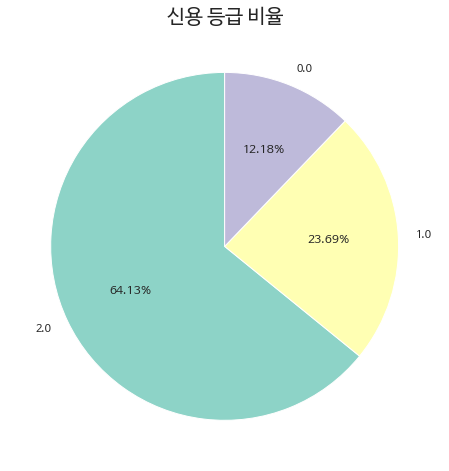

In [18]:
plt.subplots(figsize = (8,8))
plt.pie(train['credit'].value_counts(), labels = train['credit'].value_counts().index, 
        autopct="%.2f%%", startangle = 90)
plt.title('신용 등급 비율', size=20)
plt.show()

In [19]:
def bar_chart(data,feature):
  credit_0 = data[data['credit']==0][feature].value_counts(normalize=True)
  credit_1 = data[data['credit']==1][feature].value_counts(normalize=True)
  credit_2 = data[data['credit']==2][feature].value_counts(normalize=True)

  df = pd.DataFrame([credit_0,credit_1,credit_2])
  df.index = ['credit_0','credit_1','credit_2']
  df = df.T
  df = df.reset_index()
  
  df.plot(x='index',kind='barh',stacked=True, title=feature, mark_right = True,figsize=(16, 6))

  df_total = df["credit_0"] + df["credit_1"] + df["credit_2"]
  df_rel = df[df.columns[1:]].div(df_total, 0) * 100
    
  for n in df_rel:
      for i, (cs, ab, pc) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], 
                                          df[n], df_rel[n])):
          plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
                  va = 'center', ha = 'center', rotation = 0, fontsize = 8)

신용 등급에 따라 성별 차이가 존재하는가 ?

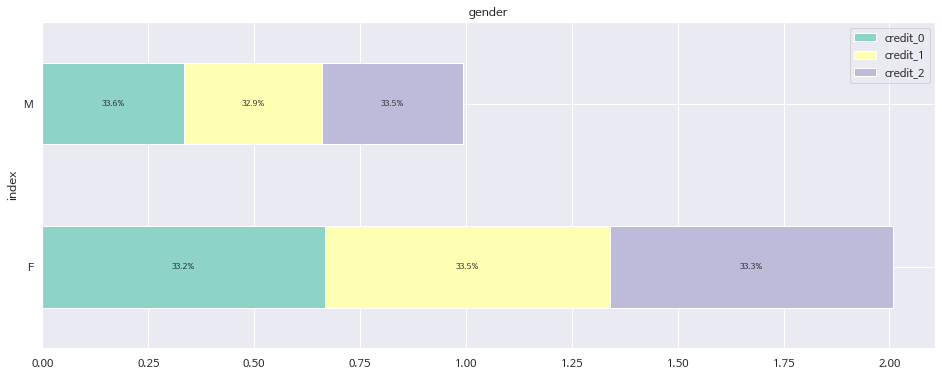

In [20]:
bar_chart(train,'gender')

- 모든 등급에서 여성이 더 많음

신용 등급에 따라 부동산 소유의 차이 존재하는가?

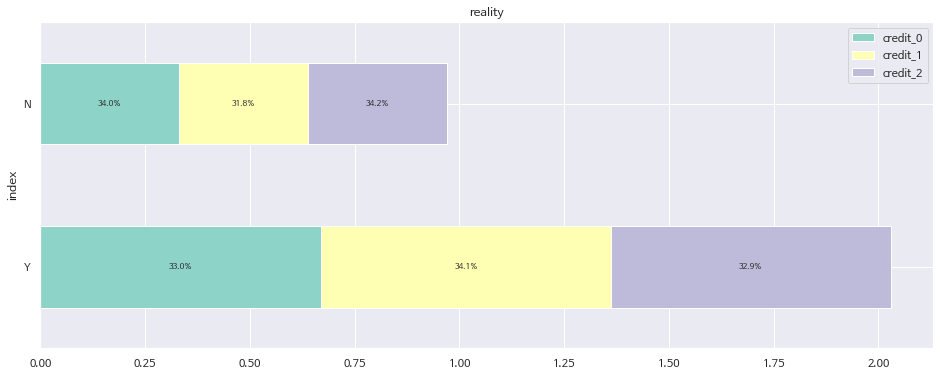

In [21]:
bar_chart(train,'reality')

- 모든 등급에서 부동산을 소유하고 있는 사람들이 많다.

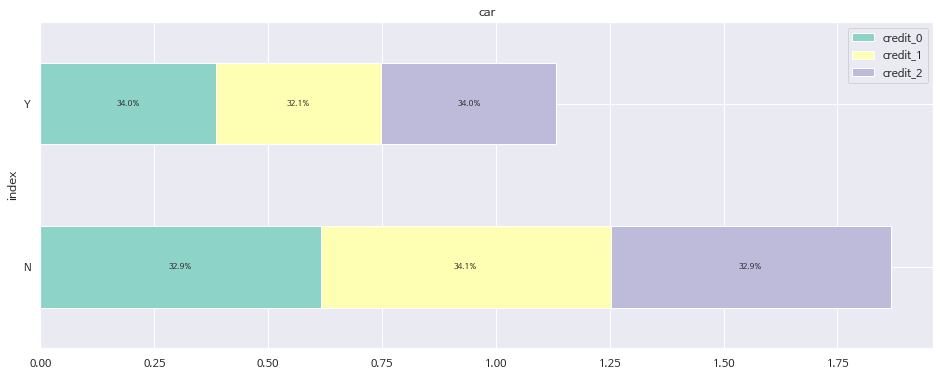

In [22]:
bar_chart(train,'car')

* 모든 등급에서 차를 소유하고 있지 않은 사람들이 많다. 

신용 등급에 따라 소득 분류의 차이

In [23]:
def multicat_plot(data,feature):

  f, ax = plt.subplots(1, 3, figsize=(16, 6))

  credit_0 = data[data['credit']==0]
  credit_1 = data[data['credit']==1]
  credit_2 = data[data['credit']==2]

  
  sns.countplot(x = feature,
                data = credit_0,
                ax = ax[0],
                order = credit_0[feature].value_counts().index) # 큰 수부터 정렬
  
  
  ax[0].tick_params(labelsize=12)
  ax[0].set_title('credit_0')
  ax[0].set_ylabel('count')
  ax[0].tick_params(axis='x',rotation=50)

  for p in ax[0].patches:
    ax[0].annotate(f'\n{p.get_height()}', (p.get_x()+0.1, p.get_height()+70), color='black', size=12)


  sns.countplot(x = feature,
                data = credit_1,
                ax = ax[1],
                order = credit_1[feature].value_counts().index) 
  
  
  ax[1].tick_params(labelsize=12)
  ax[1].set_title('credit_1')
  ax[1].set_ylabel('count')
  ax[1].tick_params(axis='x', rotation=50)

  for p in ax[1].patches:
    ax[1].annotate(f'\n{p.get_height()}', (p.get_x()+0.1, p.get_height()+70), color='black', size=12)

  sns.countplot(x = feature,
                data = credit_2,
                ax = ax[2],
                order = credit_2[feature].value_counts().index)
  
  
  ax[2].tick_params(labelsize=12)
  ax[2].set_title('credit_2')
  ax[2].set_ylabel('count')
  ax[2].tick_params(axis='x',rotation=50)

  plt.subplots_adjust(wspace=0.2, hspace=0.3)
  
  for p in ax[2].patches:
    ax[2].annotate(f'\n{p.get_height()}', (p.get_x()+0.1, p.get_height()+70), color='black', size=12)
  plt.show()


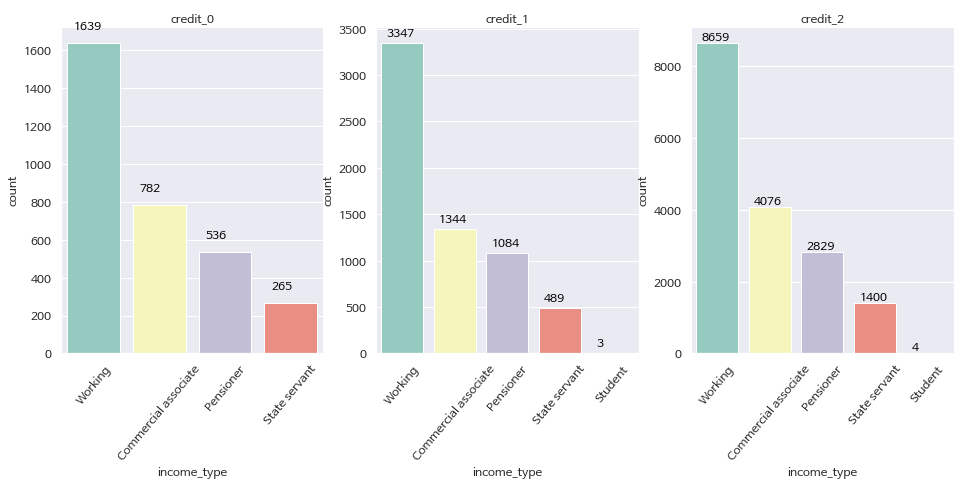

In [24]:
multicat_plot(train, 'income_type')

- 학생이 존재하지 않음

신용등급에 따라 교육 수준이 다를까?

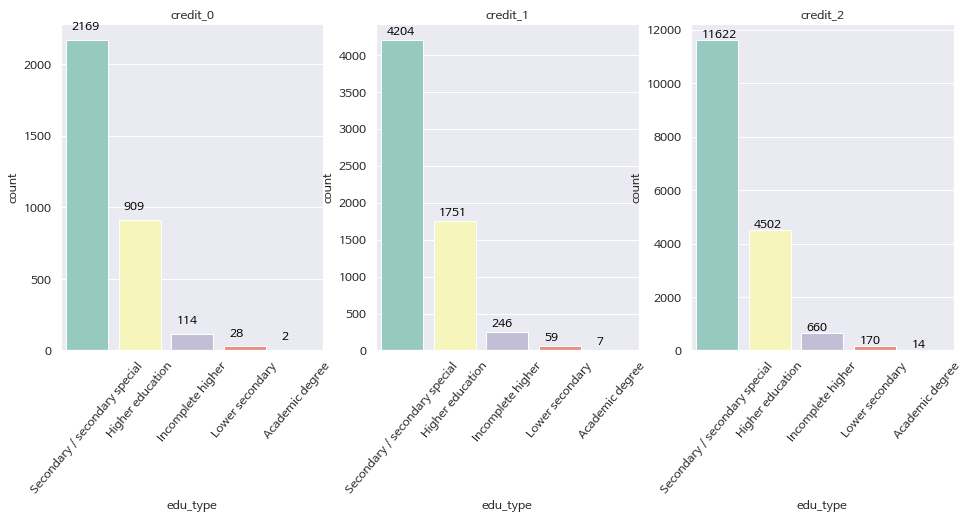

In [25]:
multicat_plot(train, 'edu_type')

- 다르지 않음

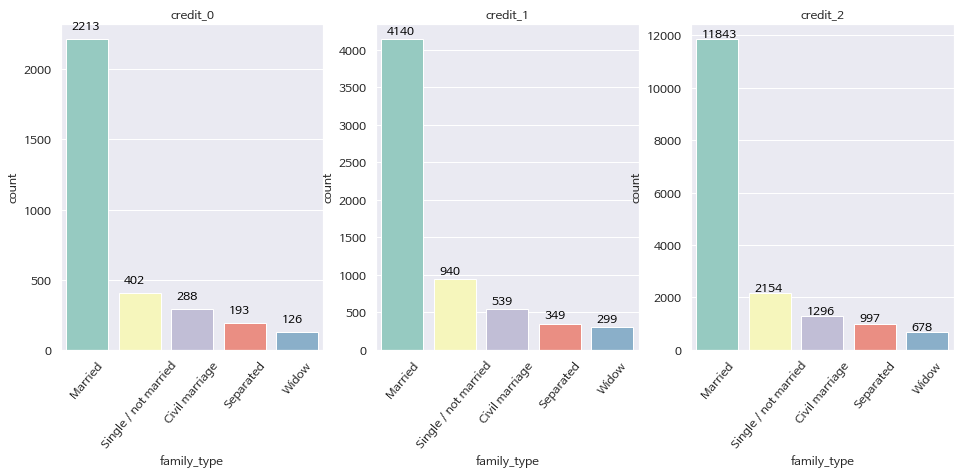

In [26]:
multicat_plot(train, 'family_type')

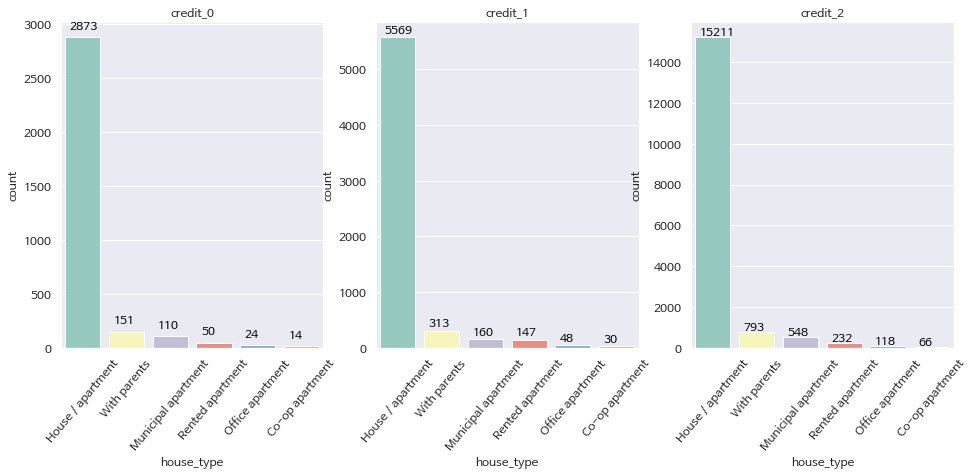

In [27]:
multicat_plot(train, 'house_type')

- 생활방식의 차이가 보이지 않는다.

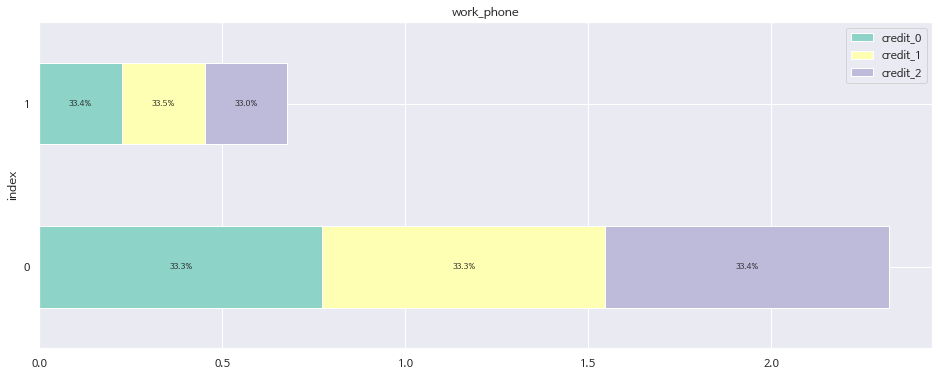

In [28]:
bar_chart(train,'work_phone')

- 차이가 보이지 않았다.

신용등급에 따라 이메일 소유 차이

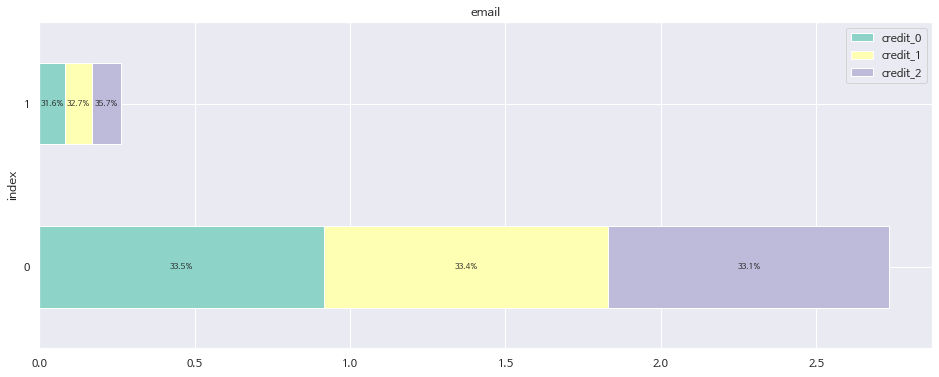

In [29]:
bar_chart(train,'email')

신용 등급별로 직업 유형의 차이

In [30]:
def multicat_plot_T(data,feature):

  f, ax = plt.subplots(1, 3, figsize=(16, 10))

  credit_0 = data[data['credit']==0]
  credit_1 = data[data['credit']==1]
  credit_2 = data[data['credit']==2]

  
  sns.countplot(y = feature,
                data = credit_0,
                ax = ax[0],
                order = credit_0[feature].value_counts().index) # 큰 수부터 정렬
  
  
  ax[0].tick_params(labelsize=12)
  ax[0].set_title('credit_0')
  ax[0].set_xlabel('count')
  


  sns.countplot(y = feature,
                data = credit_1,
                ax = ax[1],
                order = credit_1[feature].value_counts().index) 
  
  
  ax[1].tick_params(labelsize=12)
  ax[1].set_title('credit_1')
  ax[1].set_xlabel('count')
  
  sns.countplot(y = feature,
                data = credit_2,
                ax = ax[2],
                order = credit_2[feature].value_counts().index)
  
  
  ax[2].tick_params(labelsize=12)
  ax[2].set_title('credit_2')
  ax[2].set_xlabel('count')
  plt.subplots_adjust(wspace=1.2, hspace=0.3)

  plt.show()


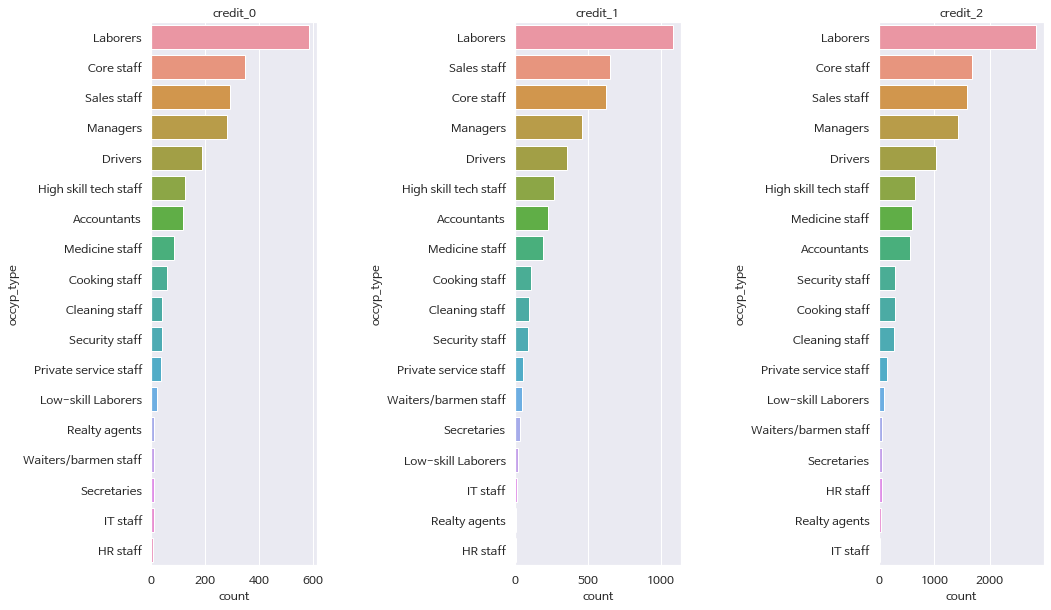

In [31]:
multicat_plot_T(train,'occyp_type')

### 연속형 변수 시각화

In [32]:
sns.set_palette("Dark2")

def num_plot(data,feature):

  f, ax = plt.subplots(1, 3, figsize=(16, 6))

  credit_0 = data[data['credit']==0]
  credit_1 = data[data['credit']==1]
  credit_2 = data[data['credit']==2]

  sns.distplot(x = credit_0[feature], ax = ax[0],
               kde=True, rug=True )
  
  ax[0].tick_params(labelsize=12)
  ax[0].set_title('credit_0')
  ax[0].set_xlabel(feature)



  sns.distplot(x = credit_1[feature],
                ax = ax[1],
               kde=True, rug=True )
  
  ax[1].tick_params(labelsize=12)
  ax[1].set_title('credit_1')
  ax[1].set_xlabel(feature)



  sns.distplot(x = credit_2[feature],
                ax = ax[2],
               kde=True, rug=True )
  
  ax[2].tick_params(labelsize=12)
  ax[2].set_title('credit_2')
  ax[2].set_xlabel(feature)


  plt.subplots_adjust(wspace=0.2, hspace=0.3)
  plt.show()

def dist_plot(data,feature): 

  credit_0 = data[data['credit']==0]
  credit_1 = data[data['credit']==1]
  credit_2 = data[data['credit']==2]

  sns.distplot(credit_0[feature],label='credit_0', hist=False, rug=True)
  sns.distplot(credit_1[feature],label='credit_1', hist=False, rug=True)
  sns.distplot(credit_2[feature],label='credit_2', hist=False, rug=True)


  plt.legend()
  plt.show()



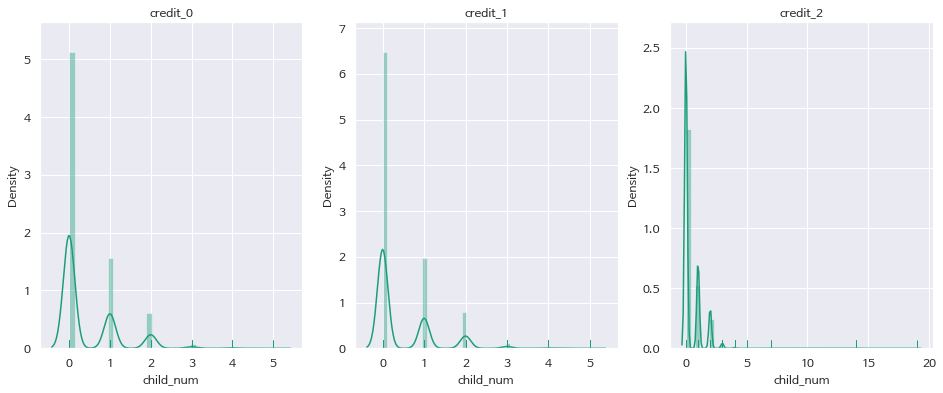

In [33]:
num_plot(train, 'child_num')

신용 등급이 낮을수록 아이의 수가 많은 듯이 보이지만, 데이터 양이 적다.

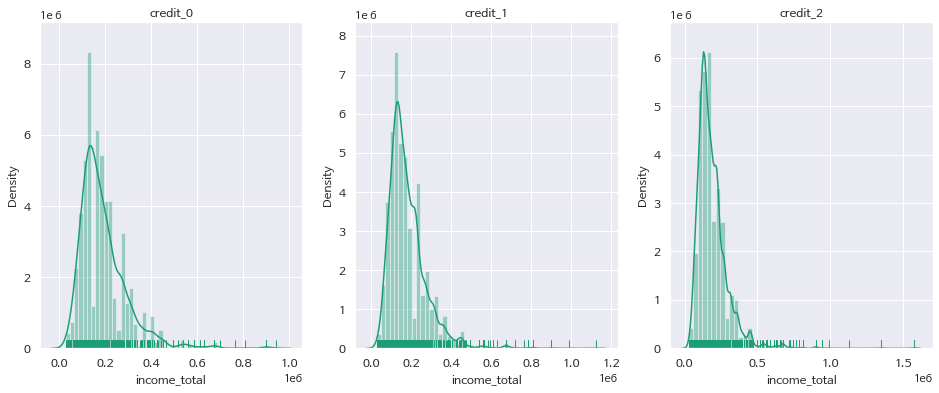

In [34]:
num_plot(train, 'income_total')

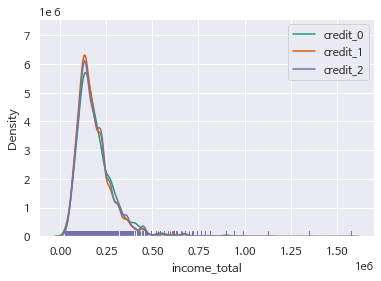

In [35]:
dist_plot(train,'income_total')

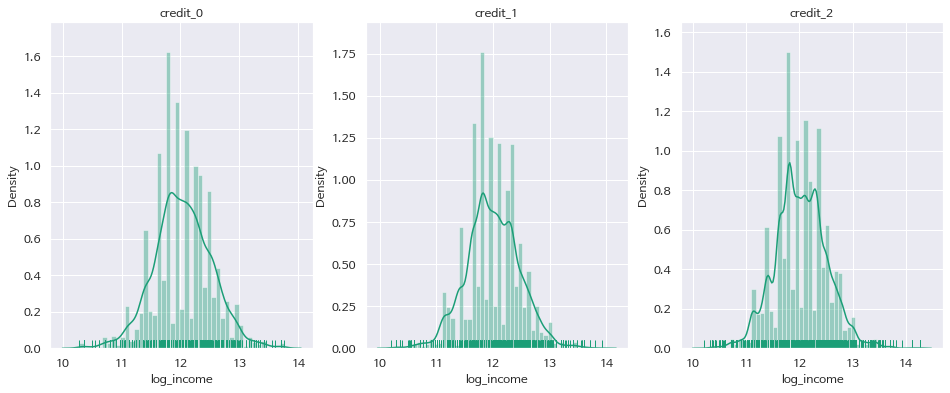

In [36]:
train['log_income'] = np.log1p(1+train['income_total'])
num_plot(train, 'log_income')

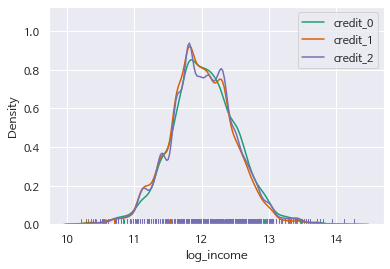

In [37]:
dist_plot(train,'log_income')
train = train.drop(columns=['log_income'])

- 상대적 비율 차이 확인

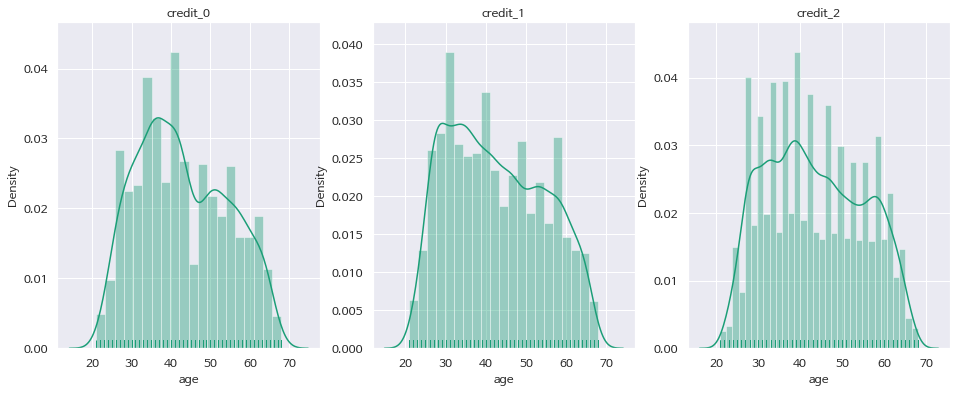

In [38]:
num_plot(train,'age')

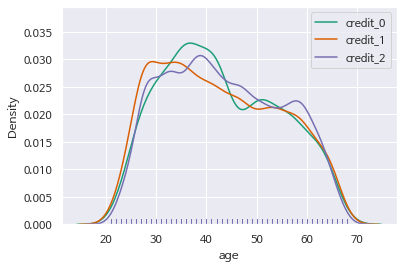

In [39]:
dist_plot(train,'age')

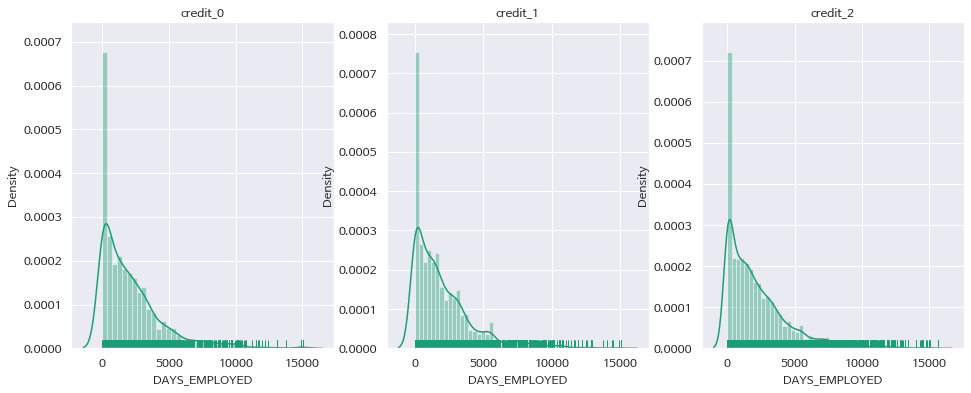

In [40]:
num_plot(train, 'DAYS_EMPLOYED')

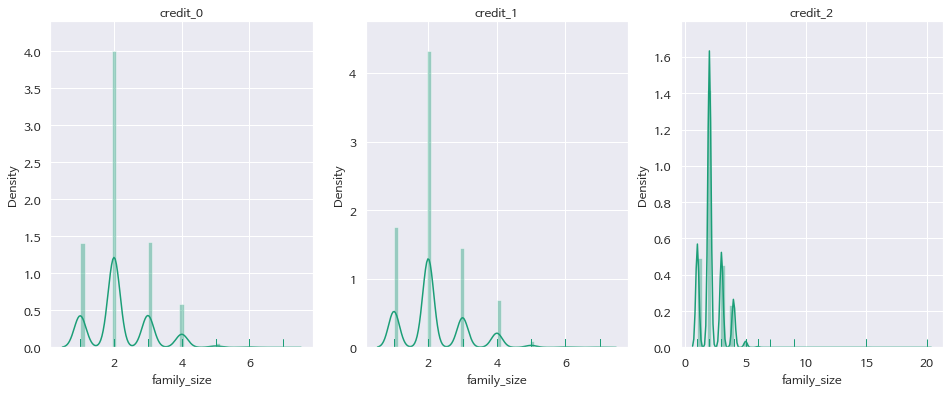

In [41]:
num_plot(train,'family_size')

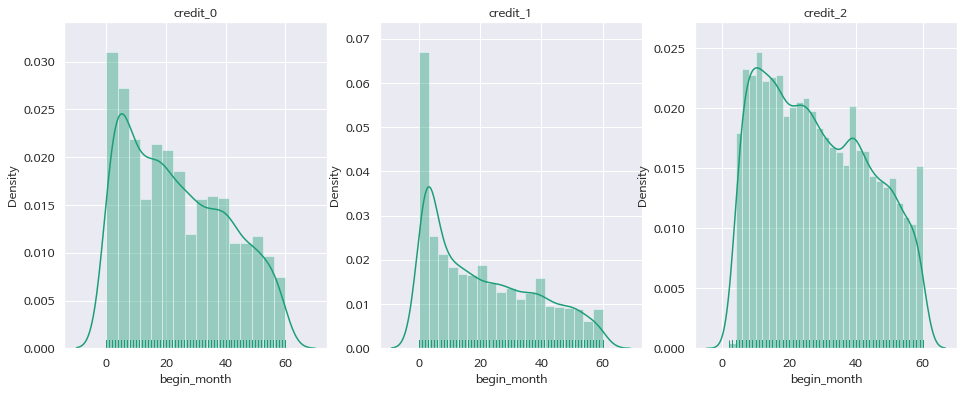

In [42]:
num_plot(train,'begin_month')

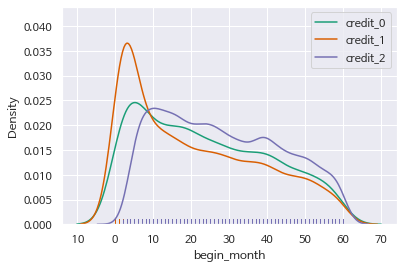

In [43]:
dist_plot(train,'begin_month')

* 가입한 지 얼마 되지 않는 사람들이 주로 신용 등급이 1임을 알 수 있다.

### 파생변수 생성

In [44]:
for df in [train,test]:
    #income_mean: 소득/ 가족 수
    df['income_respon'] = df['income_total'] / df['family_size'] # 책임, 많은 돈
    
    # ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악
    #         (begin_month, index, FLAG_MOBIL을 제거한) 16개 변수 사용
    #         한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외

    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

    df['log_income'] = np.log1p(1+df['income_total'])
    
    # df['EMPLOYED_Y']=df['DAYS_EMPLOYED']/365
    # df['EMPLOYED_M']=df['DAYS_EMPLOYED']/30
    # df['EM_zero'] = df['DAYS_EMPLOYED'].map(lambda x:1 if x==0 else 0)
    df['EM_zero_long']=df[df['DAYS_EMPLOYED']==0]['begin_month'].map(lambda x:1 if x>=10 else 0)
    df['EM_zero_long'] = df['EM_zero_long'].fillna(0)
    df['no_work_period']=df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']

    # df['INCOME_EMPLOYED_RATIO'] = df['income_total']/(df['DAYS_EMPLOYED']+1) # 
    df['EMPLOYED_BIRTH_RATIO'] = df['DAYS_EMPLOYED']/df['DAYS_BIRTH'] # 아르바이트 or 최근에 직장 옮김
    df['occyp_type'] = df['occyp_type'].fillna('NAN')


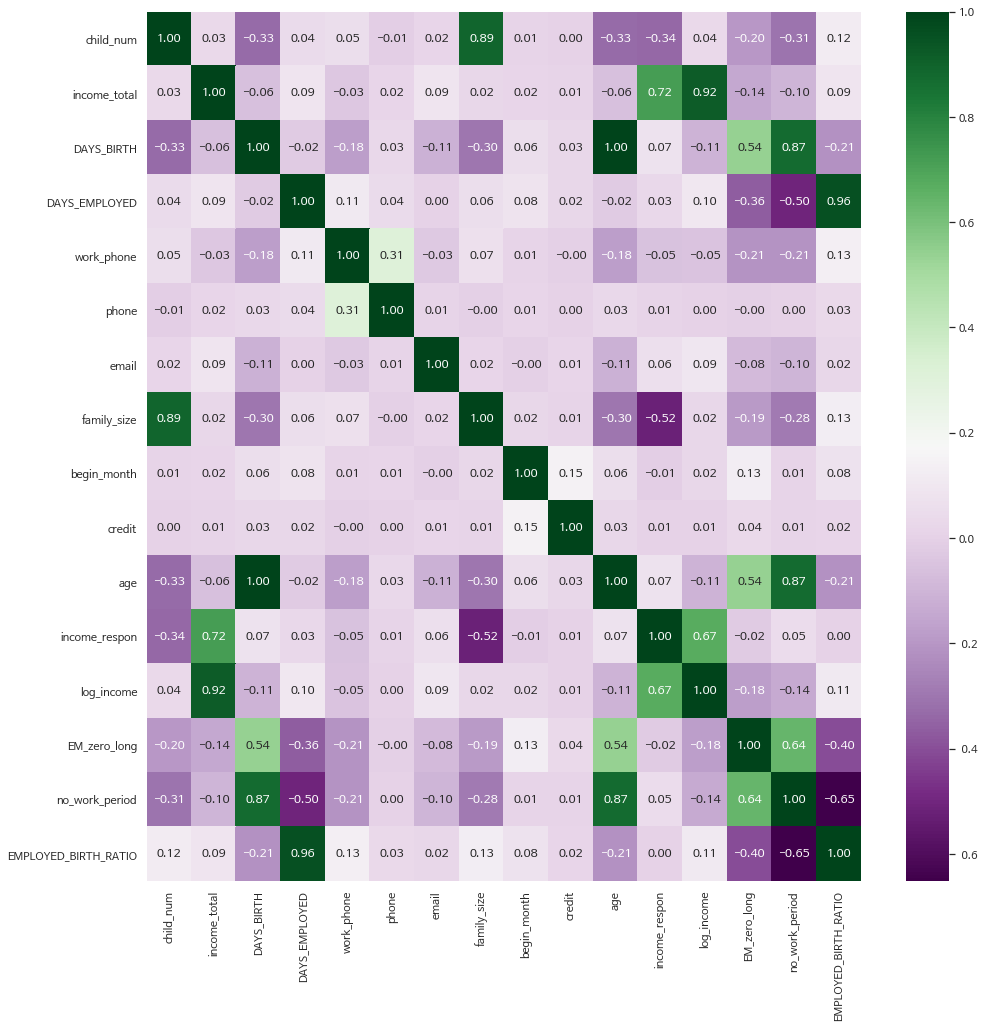

In [45]:
fig, ax = plt.subplots(figsize=(16,16))  
ax = sns.heatmap(train.corr(),annot=True,fmt='.2f',cmap="PRGn")

In [46]:
cols = ['child_num', 'DAYS_BIRTH','income_total']
train = train.drop(columns=cols)
test = test.drop(columns=cols)

- 다중 공선성이 나타나는 child_num 제거
- DAYS_BIRTH 제거 (age 사용)
- income_total 제거 (log_income 사용)


In [47]:
train.dtypes == 'object'

gender                   True
car                      True
reality                  True
income_type              True
edu_type                 True
family_type              True
house_type               True
DAYS_EMPLOYED           False
work_phone              False
phone                   False
email                   False
occyp_type               True
family_size             False
begin_month             False
credit                  False
age                     False
income_respon           False
ID                       True
log_income              False
EM_zero_long            False
no_work_period          False
EMPLOYED_BIRTH_RATIO    False
dtype: bool

In [48]:
from sklearn.preprocessing import LabelEncoder
labelenc = LabelEncoder()
train['ID'] = labelenc.fit_transform(train['ID'])

# X_test데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가한다 (중요!!!)
for label in np.unique(test['ID']):
    if label not in labelenc.classes_: # unseen label 데이터인 경우( )
        labelenc.classes_ = np.append(labelenc.classes_, label) # 미처리 시 ValueError발생

test['ID'] = labelenc.transform(test['ID'])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

In [49]:
train['ID']

0        3096
1        7301
2        5063
3        3128
4        1917
         ... 
26452    8299
26453    6928
26454    4458
26455    2359
26456    5571
Name: ID, Length: 26457, dtype: int64

### One-hot-encoding

CatBoost does not delete rows with nans


범주형 기능을 자동으로 처리: 범주를 숫자로 변환하기 위해 명시적인 사전 처리 없이 CatBoost를 사용할 수 있습니다. CatBoost는 범주 기능의 조합과 범주 및 숫자 기능의 조합에 대한 다양한 통계를 사용하여 범주 값을 숫자로 변환합니다. 

In [50]:
test.dtypes

gender                   object
car                      object
reality                  object
income_type              object
edu_type                 object
family_type              object
house_type               object
DAYS_EMPLOYED           float64
work_phone                int64
phone                     int64
email                     int64
occyp_type               object
family_size             float64
begin_month             float64
age                       int64
income_respon           float64
ID                        int64
log_income              float64
EM_zero_long            float64
no_work_period          float64
EMPLOYED_BIRTH_RATIO    float64
dtype: object

In [51]:
train.dtypes

gender                   object
car                      object
reality                  object
income_type              object
edu_type                 object
family_type              object
house_type               object
DAYS_EMPLOYED           float64
work_phone                int64
phone                     int64
email                     int64
occyp_type               object
family_size             float64
begin_month             float64
credit                  float64
age                       int64
income_respon           float64
ID                        int64
log_income              float64
EM_zero_long            float64
no_work_period          float64
EMPLOYED_BIRTH_RATIO    float64
dtype: object

In [52]:
float_feats = train.dtypes[train.dtypes == "float64"].index.tolist()
for x in float_feats : 
  train[x] = train[x].astype('int64')

float_feats = test.dtypes[test.dtypes == "float64"].index.tolist()
for x in float_feats : 
  test[x] = test[x].astype('int64')

# Data analysis


In [53]:
train.columns

Index(['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
       'house_type', 'DAYS_EMPLOYED', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit', 'age',
       'income_respon', 'ID', 'log_income', 'EM_zero_long', 'no_work_period',
       'EMPLOYED_BIRTH_RATIO'],
      dtype='object')

In [54]:
tr_y = train['credit']
tr_X = train.drop(columns=['credit'])

In [55]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3
cat_cols = ['gender', 'car', 'reality','income_type', 'edu_type','family_type','work_phone', 'phone', 'email','house_type','occyp_type','ID','EM_zero_long']

In [56]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(tr_X, tr_y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((tr_X.shape[0], n_class))
cat_pred_test = np.zeros((test.shape[0], n_class))
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = tr_X.iloc[train_idx], tr_X.iloc[valid_idx], tr_y[train_idx], tr_y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(test) / n_fold
    
print(f'\nLog Loss: {log_loss(tr_y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.115128
0:	learn: 1.0352490	test: 1.0337417	best: 1.0337417 (0)	total: 192ms	remaining: 3m 11s
100:	learn: 0.7060872	test: 0.6586572	best: 0.6585540 (89)	total: 10.2s	remaining: 1m 31s
200:	learn: 0.6884249	test: 0.6572803	best: 0.6571089 (171)	total: 21.8s	remaining: 1m 26s
300:	learn: 0.6731232	test: 0.6564446	best: 0.6558393 (287)	total: 33.6s	remaining: 1m 18s
400:	learn: 0.6578731	test: 0.6558718	best: 0.6553468 (334)	total: 45.5s	remaining: 1m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6553467683
bestIteration = 334

Shrink model to first 335 iterations.

----------------- Fold 1 -----------------

Learning rate set to 0.115128
0:	learn: 1.0351206	test: 1.0344268	best: 1.0344268 (0)	total: 131ms	remaining: 2m 10s
100:	learn: 0.7074029	test: 0.6561223	best: 0.6560851 (94)	total: 9.94s	remaining: 1m 28s
200:	learn: 0.6903117	test: 0.6523896	best: 0.6523473 (199)	total: 21.6s	remaining: 1

catboost 모델에서 cat_features 파라미터로 전달하였을 때 가장 좋은 점수를 얻을 수 있었습니다.
Category features를 사용하기 위해서는 One-Hot-Encoding등 데이터를 전처리할 필요가 있지만,
Catboost에서는 사용자가 다른 작업을 하지 않아도 자동으로 이를 변환하여 사용할 수 있습니다.

Text(0.5, 1.0, 'Feature importance')

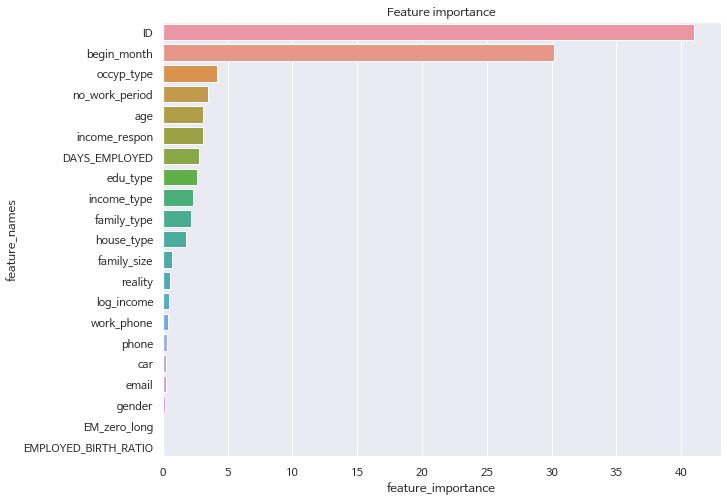

In [57]:
feature_importance = np.array(model_cat.get_feature_importance())
feature_names = np.array(tr_X.columns)

data={'feature_names':feature_names,'feature_importance':feature_importance}
data = pd.DataFrame(data)
data.sort_values(by=['feature_importance'], ascending=False,inplace=True)

plt.figure(figsize=(10,8))
sns.barplot(x=data['feature_importance'], y=data['feature_names'])
plt.title('Feature importance')
